In [1]:
import gymnasium as gym
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import scipy
from src.utils import *


### SARSA($\lambda$) 

A new count based exploration method is introduced.

The method is based on the idea of using the number of times a state-action pair has been visited to compute the exploration bonus. The exploration bonus is then added to the Q-value of the state-action pair. 

The fewer times a state-action is visited, the higher the exploration bonus. 

Furthermore, the less similar the state-action pair is to previously visited state-action pairs, the higher the exploration bonus.

The results show that the method is able to outperform the baseline method of SARSA($\lambda$); however, due to the way the features are defined in my implementation of the problem, the gain in performance is not significant.

In particular, the features are chosen using an indicator function, so each state-action pair has a unique feature vector. This means that the method is not able to generalize well to unseen states that reside in the same region of the state space (i.e. _similar_ states, in [Martin _et al_, 2017](https://arxiv.org/pdf/1706.08090.pdf)).

The performance is therefore comparable to exploration methods that assign an exploration bonus based solely on the number of times a state-action pair has been visited, independently of the similarity of the state-action pair to previously visited state-action pairs.

Further work could be done to improve the performance of the method by using a more generalizable linear feature representation.

In [3]:
"""

The following code is what can be found in .src/SARSA.py

The main difference is that an exploration bonus is added to the update of the Q-values (single_step_update function).

The exploration bonus is computed using the feature_visited_count, in the train function.

"""

class SARSA:
    def __init__(self, env, space_size, action_size, gamma=1, Qvalues=None, beta=0.5):
        """
        Calculates optimal policy using in-policy Temporal Difference control
        Evaluates Q-value for (S,A) pairs, using one-step updates.
        """
        self.env = env
        # the discount factor
        self.gamma = gamma

        # size of system
        self.space_size = space_size #is fixed to (5,5,5,5,5,5,2,2)
        self.action_size = action_size
        self.feature_size = len(space_size)
        
        self.feature_visited_count = [np.zeros(5), np.zeros(5), np.zeros(5), np.zeros(5), np.zeros(5), np.zeros(5), np.zeros(2), np.zeros(2)]
        self.beta = beta
        # where to save returns
        if Qvalues is None:
            self.Qvalues = np.zeros((*self.space_size, self.action_size))
        else:
            self.Qvalues = Qvalues

    def single_step_update(self, s, a, r, r_expl_based, new_s, new_a, done, expl_based=False):
        """
        Uses a single step to update the values, using Temporal Difference for Q values.
        Employs the EXPERIENCED action in the new state  <- Q(S_new, A_new).
        """
        self.et[(*s, a)] += 1
        expl_based_Q = np.zeros((*self.space_size, self.action_size))

        #since we are using the experienced action, we need to update the exploration bonus
        #however, the features are given by an indicator function the same number of 
        #coordinates than the space size, so we actually update only one entry
        expl_based_Q[(*new_s, new_a)] = 1
        
        # If we reached the terminal state
        if done:
            deltaQ = r + 0 - self.Qvalues[(*s, a)]
            #update the Qvalues using exploration bonus
            self.Qvalues += self.lr_v * deltaQ * self.et

        else:
            deltaQ = (
                r + self.gamma * self.Qvalues[(*new_s, new_a)] - self.Qvalues[(*s, a)]
            )
            self.Qvalues += self.lr_v * deltaQ * self.et + self.lr_v * r_expl_based * expl_based_Q
            self.et *= self.gamma * self.lambda_

    def train(
        self,
        n_episodes=10000,
        lambda_=0,
        tstar=None,
        epsilon_0=0.2,
        k_epsilon=0,
        lr_v0=0.15,
        k_lr=0,
        expl_based=False,
    ):
        """
        This function trains the agent using n_episodes.
        The default parameters use constant learning rate and epsilon (k = 0 in both cases)
        Otherwise a decaying rate is implemented after a starting point t0 (see README for more details)
        Similarly the default implements a TD(0) evaluation procedure (lambda = 0)
        """

        self.n_episodes = n_episodes

        # Add the following attributes to the class
        self.performance_traj = np.zeros(n_episodes)  # To store cumulative reward at every game

        self.et = np.zeros((*self.space_size, self.action_size))
        self.lambda_ = lambda_

        # Parameters for epsilon decay
        self.epsilon_0 = epsilon_0  # Needed to name the plots
        self.epsilon = epsilon_0  # Needed to keep track of current epsilon
        self.k_epsilon = k_epsilon

        # Parameters for learning rate decay
        self.lr_v0 = lr_v0
        self.lr_v = lr_v0
        self.k_lr = k_lr

        #to later store the cumulative mean
        self.cumulative_mean = None

        if tstar is None:
            tstar = 2.5 * n_episodes

        count = 0  # counter variable needed to see when to start decaying rates
        self.episode_star = None #registers the episode in which t_star count is reached
        # Run over episodes
        for i in range(n_episodes):
            done = False
            s, info = self.env.reset()
            s = discretize_state(s, self.space_size)

            
            a = get_action_epsilon_greedy(self.Qvalues, s, self.epsilon, self.action_size)
    
            while not done:
                count += 1
                r_expl_based=0
                # Perform one "step" in the environment
                new_s, r, truncated, terminated, info = self.env.step(a)
                new_s = discretize_state(new_s, self.space_size)

                # Exploration bonus
                if expl_based:
                    #similarity between the current state and the previous ones
                    rho_t_i = np.zeros(8)
                    for j in range(len(s)):
                        rho_t_i[j] = (self.feature_visited_count[j][new_s[j]]+(1/2))/(count+1)
                    rho_t = np.prod(rho_t_i)

                    # Update the feature visited count
                    for j in range(len(new_s)):
                        self.feature_visited_count[j][new_s[j]]+=1

                    #similarity between the new state and the previous ones, computed using the updated feature_visited_count
                    rho_t_succ_i = np.zeros(8)
                    for j in range(len(s)):
                        rho_t_succ_i[j] = (self.feature_visited_count[j][new_s[j]]+(1/2))/((count+1)+1)
                    rho_t_succ = np.prod(rho_t_succ_i)

                    # Pseudo-counts
                    N_expl_based = (rho_t*(1-rho_t_succ))/(rho_t_succ-rho_t)
                    
                    # Exploration bonus, to be added to the reward
                    r_expl_based = self.beta/np.sqrt(N_expl_based)
                
                done = terminated or truncated
                # Keep track of rewards for one episode
                self.performance_traj[i] += r

                # Choose new action index
                new_a = get_action_epsilon_greedy(self.Qvalues, new_s, self.epsilon, self.action_size)
            
                # Single update with (S, A, R', S', A')
                self.single_step_update(s, a, r, r_expl_based, new_s, new_a, done, expl_based)
                #print(self.feature_visited_count, end='\n')
                if count > tstar:
                    self.epsilon = epsilon_0 / (1.0 + self.k_epsilon * (count - tstar) ** 1.05)
                    self.lr_v = lr_v0 / (1 + self.k_lr * (count - tstar) ** 0.75)
                    if self.episode_star is None:
                        self.episode_star = i
                a = new_a
                s = new_s
            if i % 100 == 0:
                print("Episode ", i, " completed")
                print("count: ", count)
                print("r_Expl_based: ", r_expl_based)
        
    def analyse(self, n_episodes=1000):
        """
        This function analyses the agent using n_episodes.
        A greedy policy is used to choose the actions.
        """

        # Add the following attributes to the class
        self.performance_traj = np.zeros(n_episodes)
        for i in range(n_episodes):
            done = False
            s, info = self.env.reset()
            s = discretize_state(s, self.space_size)
 
            while not done:
                a = get_action_epsilon_greedy(self.Qvalues, s, 0, self.action_size)
                
                new_s, r, truncated, terminated, info = self.env.step(a)
                done = terminated or truncated
                s = discretize_state(new_s, self.space_size)
                # Keep track of rewards for one episode
                self.performance_traj[i] += r
            if i % 100 == 0:
                print("Episode ", i, " completed")
        
        #write these values into a file, in a csv like format, also reporting the parameters
        with open("data/Exploration_counts/SARSA_results.csv", "a") as f:
            f.write(str(self.lambda_) + "," + 
                    str(self.k_lr) + "," + 
                    str(self.k_epsilon) + "," + 
                    str(self.epsilon_0) + "," + 
                    str(self.cumulative_mean) + "," + 
                    str(np.mean(self.performance_traj)) + "," + 
                    str(np.std(self.performance_traj)) + "," + 
                    str(np.max(self.performance_traj)) + "," + 
                    str(np.min(self.performance_traj)) + "," + 
                    str(np.median(self.performance_traj)) + "\n")

    def plot_traj(self, cumulative=True, local=False, save_img=False):
        title = "SARSA"
        
        plot_indexes = np.arange(0, self.n_episodes + 1, 20, dtype=int)
        plot_indexes[-1] = plot_indexes[-1] - 1

        plt.plot(plot_indexes, self.performance_traj[plot_indexes])

        #plot a vertical line at episode_star
        plt.axvline(x=self.episode_star, color='black', linestyle='--')
        plt.text(self.episode_star + 10, 0, 't*', rotation=90)  
        
        if cumulative:
            cumulative_mean = np.cumsum(self.performance_traj) / np.arange(1, len(self.performance_traj) + 1)
            plt.plot(plot_indexes, cumulative_mean[plot_indexes], label="Cumulative mean")
            self.cumulative_mean = cumulative_mean[-1]
        if local:
            window_size = 100
            local_mean_SARSA = np.convolve(self.performance_traj, np.ones(window_size) / window_size, mode="valid")
            plt.plot(plot_indexes[plot_indexes < local_mean_SARSA.shape[0]],
                     local_mean_SARSA[plot_indexes[plot_indexes < local_mean_SARSA.shape[0]]],
                     label=" Local Mean", color = 'red')
            
        plt.xlabel("Episode")
        plt.ylabel("Episode reward")
        plt.legend()
        plt.suptitle(f"{title} control cumulative rewards")

        plt.title(f"$\epsilon_0$ = {self.epsilon_0}, $k_\epsilon$ = {self.k_epsilon}, $\\alpha_0$ = {self.lr_v0}, $k_{{\\alpha}}$ = {self.k_lr}, $\lambda$ = {self.lambda_}")
        plt.tight_layout()

        if save_img:
            name = (
                "Plots/Exploration_counts/SARSA_lambda_" + str(self.lambda_)
                + "_k_alpha_"
                + str(self.k_lr)
                + "k_epsilon"
                + str(self.k_epsilon)
                + "epsilon0"
                + str(self.epsilon_0)
                + "beta"
                + str(self.beta)
                + ".png"
            )
            plt.savefig(name)
        plt.show()



Episode  0  completed
count:  85
r_Expl_based:  0.5071558215820149
Episode  100  completed
count:  14732
r_Expl_based:  0.022122803888288353
Episode  200  completed
count:  29835
r_Expl_based:  0.023677595135367404
Episode  300  completed
count:  46477
r_Expl_based:  0.01856553169383796
Episode  400  completed
count:  67318
r_Expl_based:  0.014271173449615086
Episode  500  completed
count:  89007
r_Expl_based:  0.012985659786189093
Episode  600  completed
count:  113488
r_Expl_based:  0.011447566657627622
Episode  700  completed
count:  137408
r_Expl_based:  0.008648478464362237
Episode  800  completed
count:  161291
r_Expl_based:  0.007490874845131807
Episode  900  completed
count:  186912
r_Expl_based:  0.0035213759139915077
Episode  1000  completed
count:  211480
r_Expl_based:  0.007455823986113794
Episode  1100  completed
count:  238071
r_Expl_based:  0.005408619390197642
Episode  1200  completed
count:  264311
r_Expl_based:  0.006638561837484121
Episode  1300  completed
count:  29

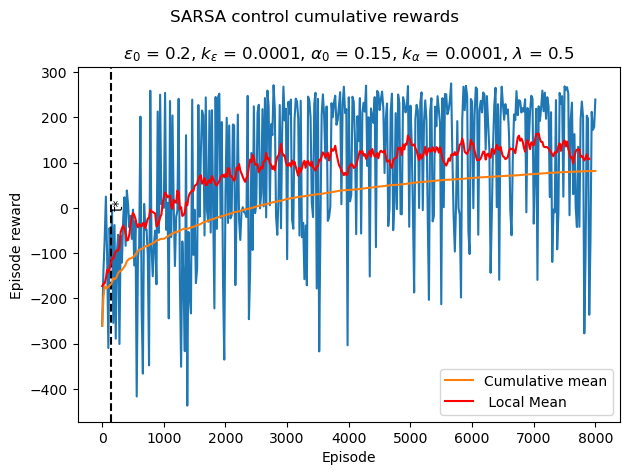

Episode  0  completed
Episode  100  completed
Episode  200  completed
Episode  300  completed
Episode  400  completed
Episode  500  completed
Episode  600  completed
Episode  700  completed
Episode  800  completed
Episode  900  completed
Episode  1000  completed
Episode  1100  completed
Episode  1200  completed
Episode  1300  completed
Episode  1400  completed
Episode  1500  completed
Episode  1600  completed
Episode  1700  completed
Episode  1800  completed
Episode  1900  completed


In [4]:
beta = 0.5
env = gym.make('LunarLander-v2')
observation_space = [5,5,5,5,5,5,2,2]

sarsa = SARSA(env, space_size=observation_space, action_size=4, gamma=1, beta=0.5)
sarsa.train(n_episodes=8000, lambda_=0.5, epsilon_0=0.2, k_epsilon=0.0001, k_lr=0.0001, expl_based=True)
sarsa.plot_traj(cumulative=True, local=True, save_img=True)
sarsa.analyse(n_episodes=2000)


Episode  0  completed
count:  103
r_Expl_based:  0
Episode  100  completed
count:  13803
r_Expl_based:  0
Episode  200  completed
count:  28633
r_Expl_based:  0
Episode  300  completed
count:  46837
r_Expl_based:  0
Episode  400  completed
count:  65747
r_Expl_based:  0
Episode  500  completed
count:  87954
r_Expl_based:  0
Episode  600  completed
count:  110297
r_Expl_based:  0
Episode  700  completed
count:  133002
r_Expl_based:  0
Episode  800  completed
count:  158149
r_Expl_based:  0
Episode  900  completed
count:  183601
r_Expl_based:  0
Episode  1000  completed
count:  213328
r_Expl_based:  0
Episode  1100  completed
count:  244385
r_Expl_based:  0
Episode  1200  completed
count:  277416
r_Expl_based:  0
Episode  1300  completed
count:  310693
r_Expl_based:  0
Episode  1400  completed
count:  346284
r_Expl_based:  0
Episode  1500  completed
count:  381098
r_Expl_based:  0
Episode  1600  completed
count:  418366
r_Expl_based:  0
Episode  1700  completed
count:  454551
r_Expl_base

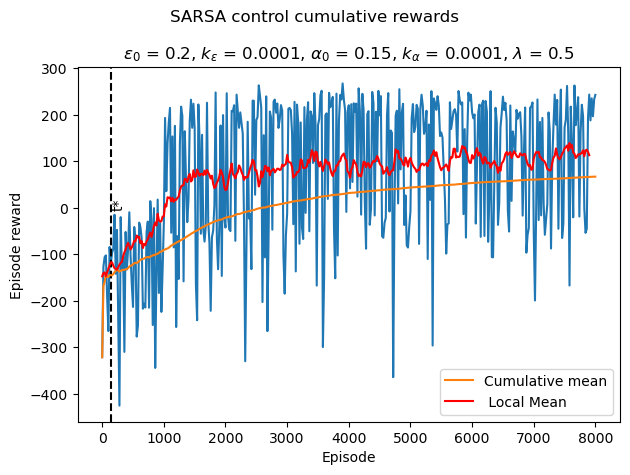

Episode  0  completed
Episode  100  completed
Episode  200  completed
Episode  300  completed
Episode  400  completed
Episode  500  completed
Episode  600  completed
Episode  700  completed
Episode  800  completed
Episode  900  completed
Episode  1000  completed
Episode  1100  completed
Episode  1200  completed
Episode  1300  completed
Episode  1400  completed
Episode  1500  completed
Episode  1600  completed
Episode  1700  completed
Episode  1800  completed
Episode  1900  completed


In [5]:
sarsa = SARSA(env, space_size=observation_space, action_size=4, gamma=1, beta=0)
sarsa.train(n_episodes=8000, lambda_=0.5, epsilon_0=0.2, k_epsilon=0.0001, k_lr=0.0001, expl_based=False)
sarsa.plot_traj(cumulative=True, local=True, save_img=True)
sarsa.analyse(n_episodes=2000)

In [2]:
#load the results from the csv file
import pandas as pd

df = pd.read_csv("data/Exploration_counts/SARSA_results.csv", header=None)
df

,0,1,2,3,4,5,6,7,8,9
0,lambda,k_alpha,k_epsilon,epsilon_0,cumulative_mean,mean,std,max,min,median
1,0.5,0.0001,0.0001,0.2,81.36613465664105,126.4586073123794,143.85998615535084,281.1231846880225,-425.3939570397464,199.61782172182194
2,0.5,0.0001,0.0001,0.2,67.11628619634723,105.96528109527878,137.7968037996547,280.3971901395885,-428.66335859443706,176.54316037652217


Sarsa($\lambda$) with exploration bonus (first row) is marginally better.

Note: these results are not consistent with the ones reported in the github presentation due to further reduction of the state space (dimension 1 went from 7 to 5 states), to speedup the training.